# YouTube Trend Analysis Report

## Introduction

This notebook, titled "YouTube Trend Analysis with LocalStack S3", is designed for data exploration and visualization of YouTube trending video data. The primary objective is to uncover insights into video trends across various categories, channels, and geographical regions. By examining these trends, the analysis aims to provide valuable information that can help content creators, marketers, and researchers understand the factors contributing to video popularity on YouTube. Understanding YouTube trends is crucial for optimizing content strategies, as it allows stakeholders to align their content with audience preferences, thereby increasing engagement and reach (YouTube Trends Guide).

## Data Sources and Tools

The data used in this analysis is sourced from processed datasets stored in LocalStack S3, which include category analysis, channel analysis, and daily trends. LocalStack simulates AWS S3 services locally, facilitating development and testing without incurring cloud costs ([LocalStack Documentation](https://docs.localstack.cloud/overview/)). The analysis employs a range of data science libraries, including:

- Pandas and NumPy for data manipulation and numerical computations.
- Matplotlib and Seaborn for creating static visualizations.
- Boto3 for interacting with S3 services.
- PySpark for processing large datasets.
- Plotly for generating interactive visualizations.

These tools enable efficient data handling, analysis, and presentation of results in both static and interactive formats.

For raw data, I used the ["Trending YouTube Video Statistics" dataset](https://www.kaggle.com/datasets/datasnaek/youtube-new) by [Mitchell J (datasnaek)](https://www.kaggle.com/datasnaek) from [Kaggle](https://www.kaggle.com/datasets/datasnaek/youtube-new).

### 1. Setup and Configuration

#### 1.1. Importing packages

This section initializes the analysis environment by importing necessary libraries and setting visualization styles. The libraries include Pandas, NumPy, Matplotlib, Seaborn, Boto3, PySpark, and Plotly. The plot style is set to `'seaborn-v0_8'` with the `'husl'` color palette for consistent and aesthetically pleasing visuals. Warnings are suppressed to ensure clean output.

In [1]:
"""
YouTube Trend Analysis with LocalStack S3
Notebook for data exploration and visualization
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from pyspark.sql import SparkSession
import plotly.express as px
import os
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
import warnings

# Type import
from mypy_boto3_s3 import S3Client


warnings.filterwarnings("ignore")

# Set style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")


#### 1.2. LocalStack S3 and Spark Configuration

This section configures the connection to LocalStack S3 and initializes a Spark session. It defines:
- S3 Client Configuration: Sets up a Boto3 client with a local endpoint (http://localstack:4566), test credentials, and the 'us-east-1' region, all are set in [.env](../.env.example) and loaded from [environment variables](../docker-compose.yml) (see service.jupyter).
- Spark Session Configuration: Creates a Spark session with configurations to support S3 access, including path-style access and disabling SSL for local testing. This setup ensures seamless interaction with the LocalStack S3 environment.

In [2]:


# LocalStack S3 Configuration
LOCALSTACK_ENDPOINT = os.getenv("S3_ENDPOINT_URL")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_DEFAULT_REGION = os.getenv("AWS_DEFAULT_REGION")
# Expected values:
# LOCALSTACK_ENDPOINT = "http://localstack:4566"
# AWS_ACCESS_KEY_ID = "test"
# AWS_SECRET_ACCESS_KEY = "test"
# AWS_DEFAULT_REGION = "us-east-1"

# Bucket names
RAW_BUCKET = os.getenv("RAW_BUCKET")  # Raw dataset storage
PROCESSED_BUCKET = os.getenv("PROCESSED_BUCKET")  # Processed data
ANALYTICS_BUCKET = os.getenv("ANALYTICS_BUCKET")  # Analytics results

def create_s3_client() -> S3Client:
    """Create S3 client for LocalStack"""
    return boto3.client(
        "s3", 
        endpoint_url=LOCALSTACK_ENDPOINT,
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY, 
        region_name=AWS_DEFAULT_REGION
    )


def create_spark_session() -> SparkSession:
    """Create Spark session with LocalStack S3 support"""
    return (
        SparkSession.builder.appName("YouTubeAnalysis_Notebook")
        .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
        .config("spark.hadoop.fs.s3a.access.key", AWS_ACCESS_KEY_ID)
        .config("spark.hadoop.fs.s3a.secret.key", AWS_SECRET_ACCESS_KEY)
        .config("spark.hadoop.fs.s3a.endpoint", LOCALSTACK_ENDPOINT)
        .config("spark.hadoop.fs.s3a.path.style.access", "true")
        .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false")
        .getOrCreate()
    )


#### 1.3. Connection Initialization and Testing

Here, the notebook establishes connections to LocalStack S3 and initializes the Spark session. It tests the S3 connection by listing available buckets, printing a success message with bucket names if successful, or an error message if the connection fails. The Spark session's log level is set to "ERROR" to minimize verbose output.

In [3]:
# Initialize connections
print("Connecting to LocalStack S3...")
s3_client = create_s3_client()

print("Initializing Spark Session...")
spark = create_spark_session()
spark.sparkContext.setLogLevel("ERROR")

# Test S3 connection
try:
    buckets = s3_client.list_buckets()
    print("Connected to LocalStack S3")
    print(f"Available buckets: {[b['Name'] for b in buckets['Buckets']]}")
except Exception as e:
    print(f"Failed to connect to LocalStack: {e}")


Connecting to LocalStack S3...
Initializing Spark Session...
Connected to LocalStack S3
Available buckets: ['youtube-trending-analytics', 'youtube-trending-processed', 'youtube-trending-raw']


#### 1.4. Data Loading from S3

This section loads processed data from three S3 paths:
- `s3a://{PROCESSED_BUCKET}/category_analysis`
- `s3a://{PROCESSED_BUCKET}/channel_analysis`
- `s3a://{PROCESSED_BUCKET}/daily_trends`

The data is read as Spark DataFrames, and the number of records in each dataset is printed. Error handling ensures that any issues during data loading are caught, with a reminder to verify that the Airflow pipeline has run successfully.

In [4]:
# Load processed data from LocalStack S3
print("Loading processed data from S3...")
try:
    # Load analytics data
    category_df = spark.read.parquet(f"s3a://{PROCESSED_BUCKET}/category_analysis")
    channel_df = spark.read.parquet(f"s3a://{PROCESSED_BUCKET}/channel_analysis")
    daily_df = spark.read.parquet(f"s3a://{PROCESSED_BUCKET}/daily_trends")

    print(f"Category analysis: {category_df.count()} records")
    print(f"Channel analysis: {channel_df.count()} records")
    print(f"Daily trends: {daily_df.count()} records")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Make sure the Airflow pipeline has run successfully. Please check the DAG at http://localhost:8080")


Loading processed data from S3...
Category analysis: 167 records
Channel analysis: 29503 records
Daily trends: 1967 records


#### 1.5. Data Conversion to Pandas

The Spark DataFrames are converted to Pandas DataFrames to facilitate visualization and analysis using Python's data science libraries. This step is crucial as Pandas is more suited for the subsequent visualization tasks with Matplotlib, Seaborn, and Plotly.

In [5]:
# Convert Spark DataFrames to Pandas for visualization
print("Converting to Pandas DataFrames...")
category_pd = category_df.toPandas()
channel_pd = channel_df.toPandas()
daily_pd = daily_df.toPandas()
print("Data conversion completed")


Converting to Pandas DataFrames...
Data conversion completed


#### 1.6. Data Overview

This section provides a high-level summary of the dataset, including:
- Number of countries analyzed.
- Number of unique categories.
- Number of unique channels.
- Date range of the trending data.

These metrics offer a quick snapshot of the dataset's scope and coverage.

In [6]:
# Data Overview
print("Data Overview")
print("=" * 50)
print(f"Countries analyzed: {category_pd['country'].nunique()}")
print(f"Unique categories: {category_pd['category_id'].nunique()}")
print(f"Unique channels: {channel_pd['channel_title'].nunique()}")
print(f"Date range: {daily_pd['trending_date_parsed'].min()} to {daily_pd['trending_date_parsed'].max()}")

Data Overview
Countries analyzed: 10
Unique categories: 18
Unique channels: 24388
Date range: 2017-11-14 to 2018-06-14


### 2. Analysis

#### 2.1. Category Performance Analysis
This section analyzes video categories based on:
- Total Views: Visualizes the top 10 categories by total views using a bar chart.
- Average Views: Displays the top 10 categories by average views.
- Engagement Rate: Shows the top 10 categories by average engagement rate.
- Video Count: Illustrates the top 10 categories by total video count.

Four subplots are created using Matplotlib to present these metrics.

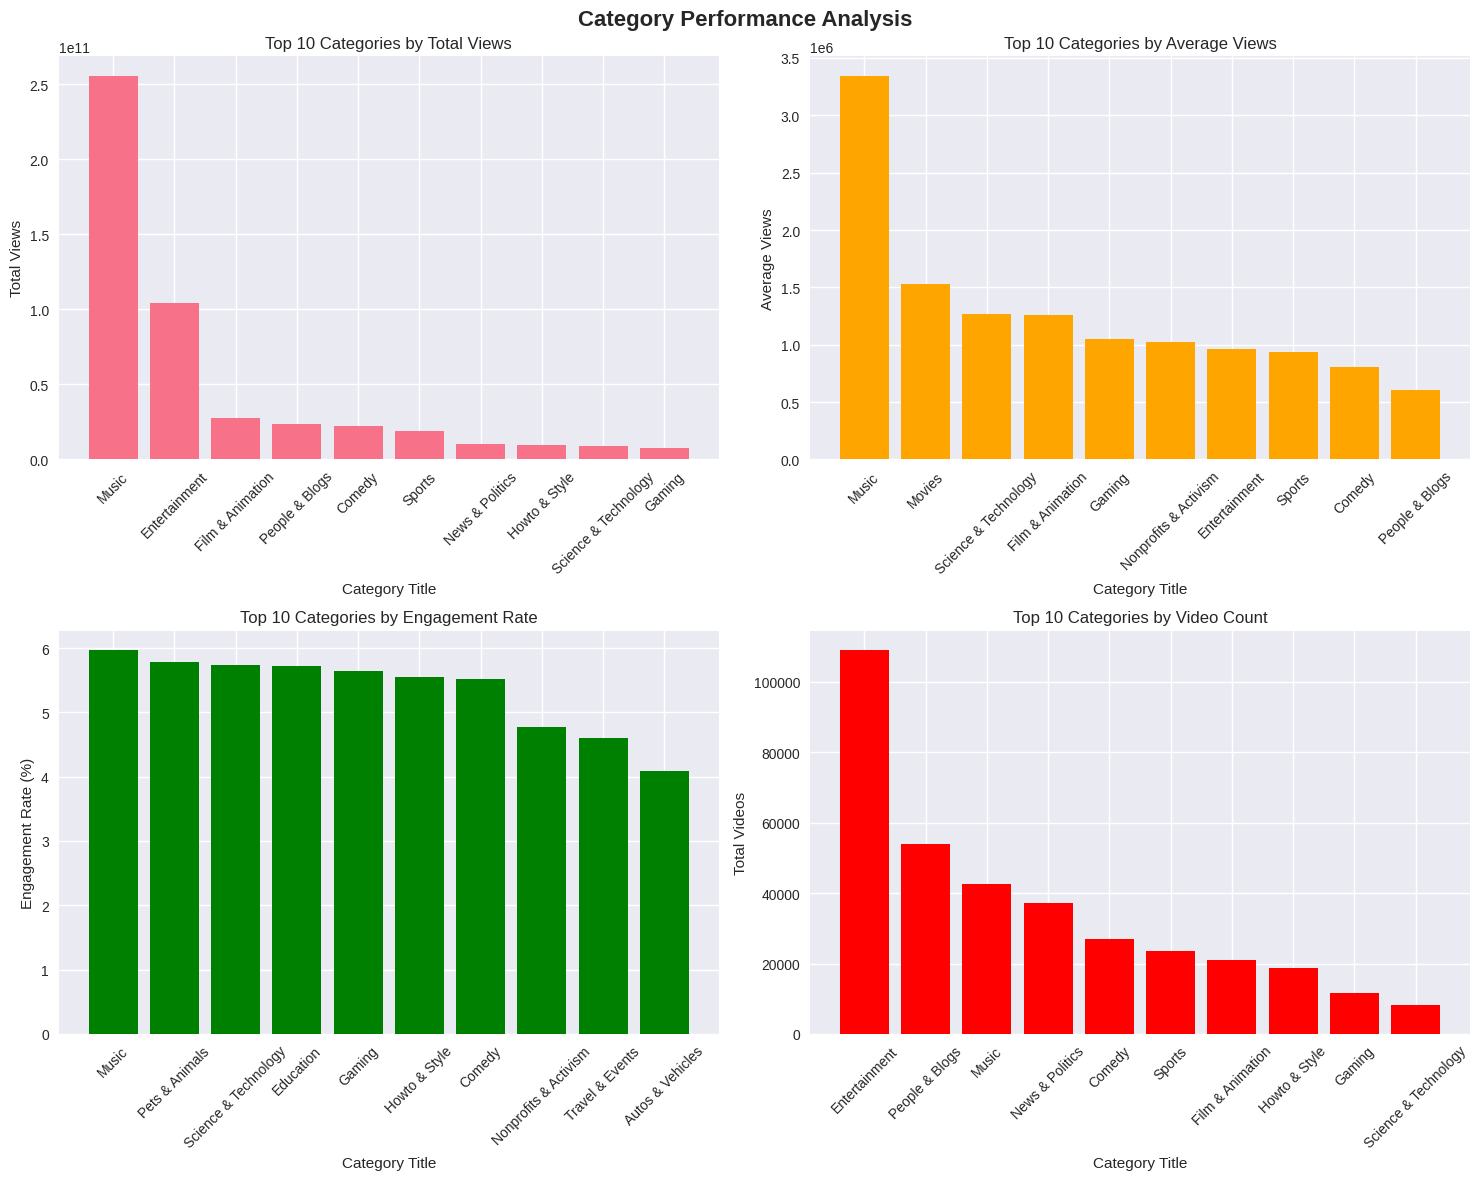

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Category Performance Analysis", fontsize=16, fontweight="bold")

# Top categories by total views
top_categories = category_pd.groupby("category_title")["total_views"].sum().sort_values(ascending=False).head(10)
axes[0, 0].bar(range(len(top_categories)), top_categories.values)
axes[0, 0].set_title("Top 10 Categories by Total Views")
axes[0, 0].set_xlabel("Category Title")
axes[0, 0].set_ylabel("Total Views")
axes[0, 0].set_xticks(range(len(top_categories)))
axes[0, 0].set_xticklabels(top_categories.index, rotation=45)

# Average views by category
avg_views = category_pd.groupby("category_title")["avg_views"].mean().sort_values(ascending=False).head(10)
axes[0, 1].bar(range(len(avg_views)), avg_views.values, color="orange")
axes[0, 1].set_title("Top 10 Categories by Average Views")
axes[0, 1].set_xlabel("Category Title")
axes[0, 1].set_ylabel("Average Views")
axes[0, 1].set_xticks(range(len(avg_views)))
axes[0, 1].set_xticklabels(avg_views.index, rotation=45)

# Engagement rate by category
engagement = category_pd.groupby("category_title")["avg_engagement_rate"].mean().sort_values(ascending=False).head(10)
axes[1, 0].bar(range(len(engagement)), engagement.values, color="green")
axes[1, 0].set_title("Top 10 Categories by Engagement Rate")
axes[1, 0].set_xlabel("Category Title")
axes[1, 0].set_ylabel("Engagement Rate (%)")
axes[1, 0].set_xticks(range(len(engagement)))
axes[1, 0].set_xticklabels(engagement.index, rotation=45)

# Video count by category
video_count = category_pd.groupby("category_title")["video_count"].sum().sort_values(ascending=False).head(10)
axes[1, 1].bar(range(len(video_count)), video_count.values, color="red")
axes[1, 1].set_title("Top 10 Categories by Video Count")
axes[1, 1].set_xlabel("Category Title")
axes[1, 1].set_ylabel("Total Videos")
axes[1, 1].set_xticks(range(len(video_count)))
axes[1, 1].set_xticklabels(video_count.index, rotation=45)

plt.tight_layout()
plt.show()


#### 2.2. Geographic Analysis

This section examines video trends across different countries, focusing on:
- Total Views: A pie chart showing market share by country.
- Average Engagement Rate: A bar chart of engagement rates by country.
- Video Count: A bar chart of total videos by country.
- Category Diversity: A bar chart of unique categories per country.

The engagement rate is calculated as:

$$\text{Engagement Rate (\%)} = \frac{\text{Likes} + \text{Dislikes} + \text{Comment Count}}{\text{Views}} \times 100 $$



These visualizations highlight geographical differences in video consumption and engagement.

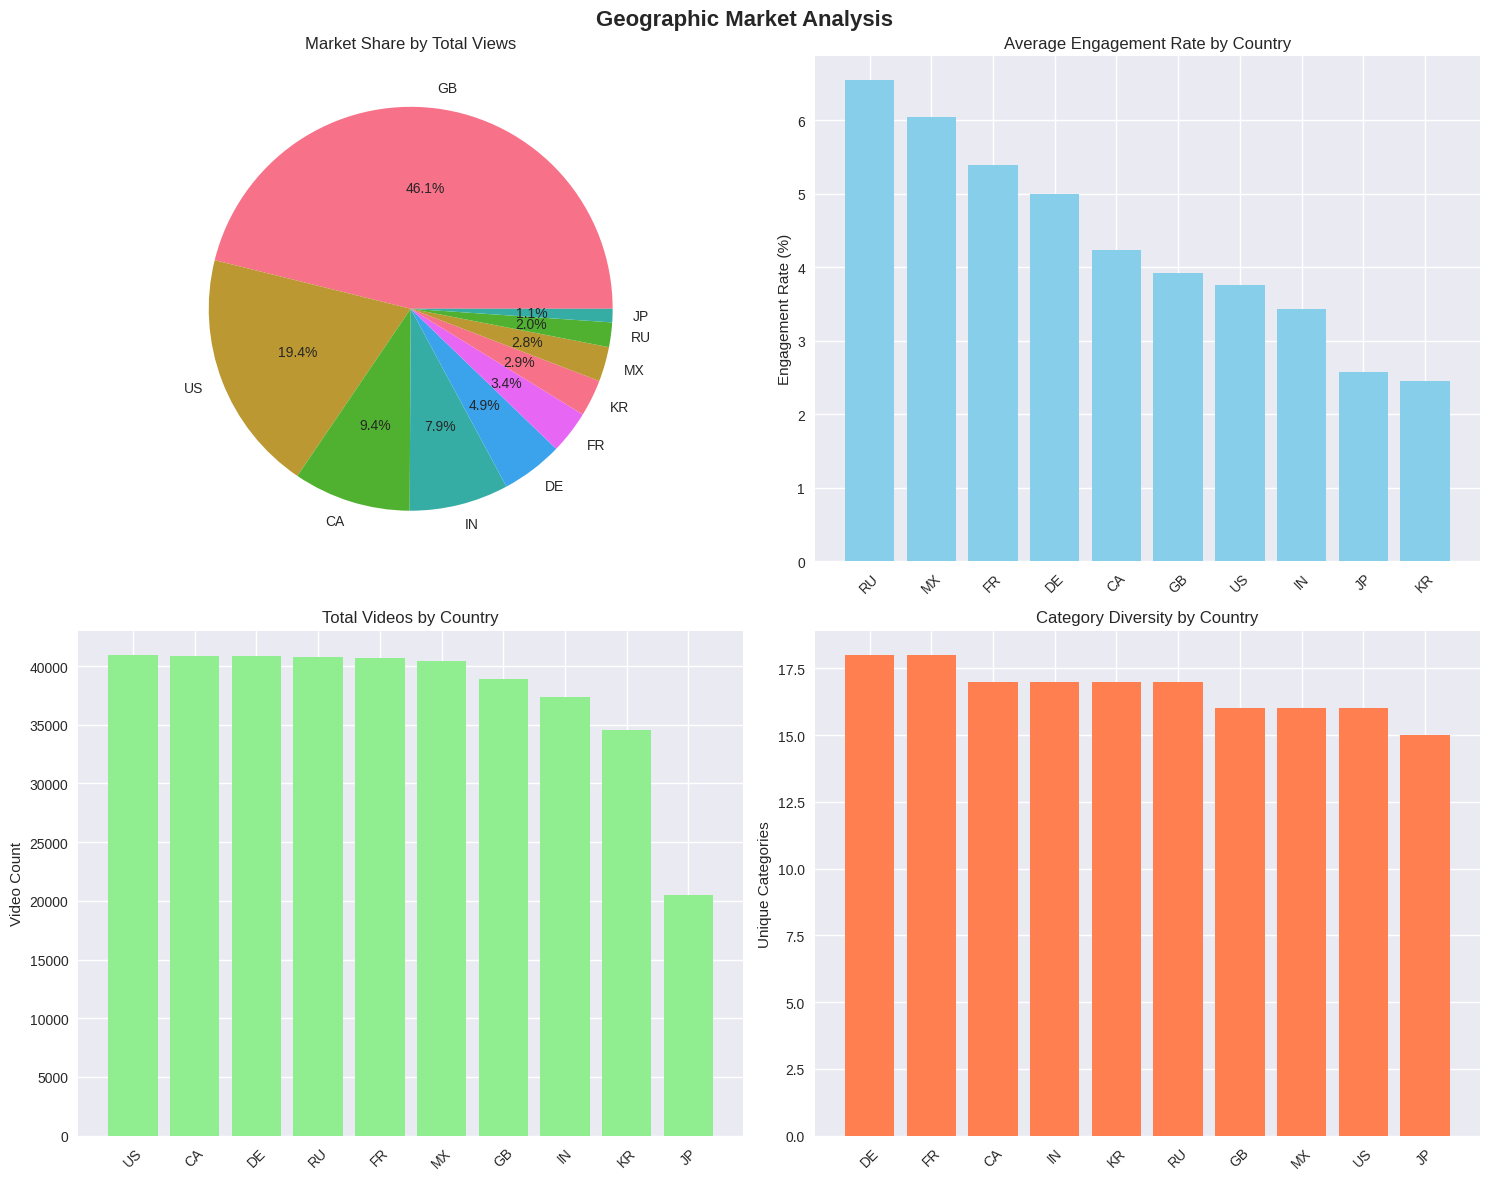

In [8]:
# 2. Geographic Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Geographic Market Analysis", fontsize=16, fontweight="bold")

# Total views by country
country_views = category_pd.groupby("country")["total_views"].sum().sort_values(ascending=False)
axes[0, 0].pie(country_views.values, labels=country_views.index, autopct="%1.1f%%")
axes[0, 0].set_title("Market Share by Total Views")

# Average engagement by country
country_engagement = category_pd.groupby("country")["avg_engagement_rate"].mean().sort_values(ascending=False)
axes[0, 1].bar(country_engagement.index, country_engagement.values, color="skyblue")
axes[0, 1].set_title("Average Engagement Rate by Country")
axes[0, 1].set_ylabel("Engagement Rate (%)")
axes[0, 1].tick_params(axis="x", rotation=45)

# Video count by country
country_videos = category_pd.groupby("country")["video_count"].sum().sort_values(ascending=False)
axes[1, 0].bar(country_videos.index, country_videos.values, color="lightgreen")
axes[1, 0].set_title("Total Videos by Country")
axes[1, 0].set_ylabel("Video Count")
axes[1, 0].tick_params(axis="x", rotation=45)

# Categories per country
country_categories = category_pd.groupby("country")["category_id"].nunique().sort_values(ascending=False)
axes[1, 1].bar(country_categories.index, country_categories.values, color="coral")
axes[1, 1].set_title("Category Diversity by Country")
axes[1, 1].set_ylabel("Unique Categories")
axes[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


#### 2.3. Channel Success Analysis

This section identifies the top 15 channels by average views and visualizes them in a horizontal bar chart, with bars colored by country. A legend indicates the country of origin, providing insights into which channels perform best and their geographical distribution.

Top Performing Channels Analysis


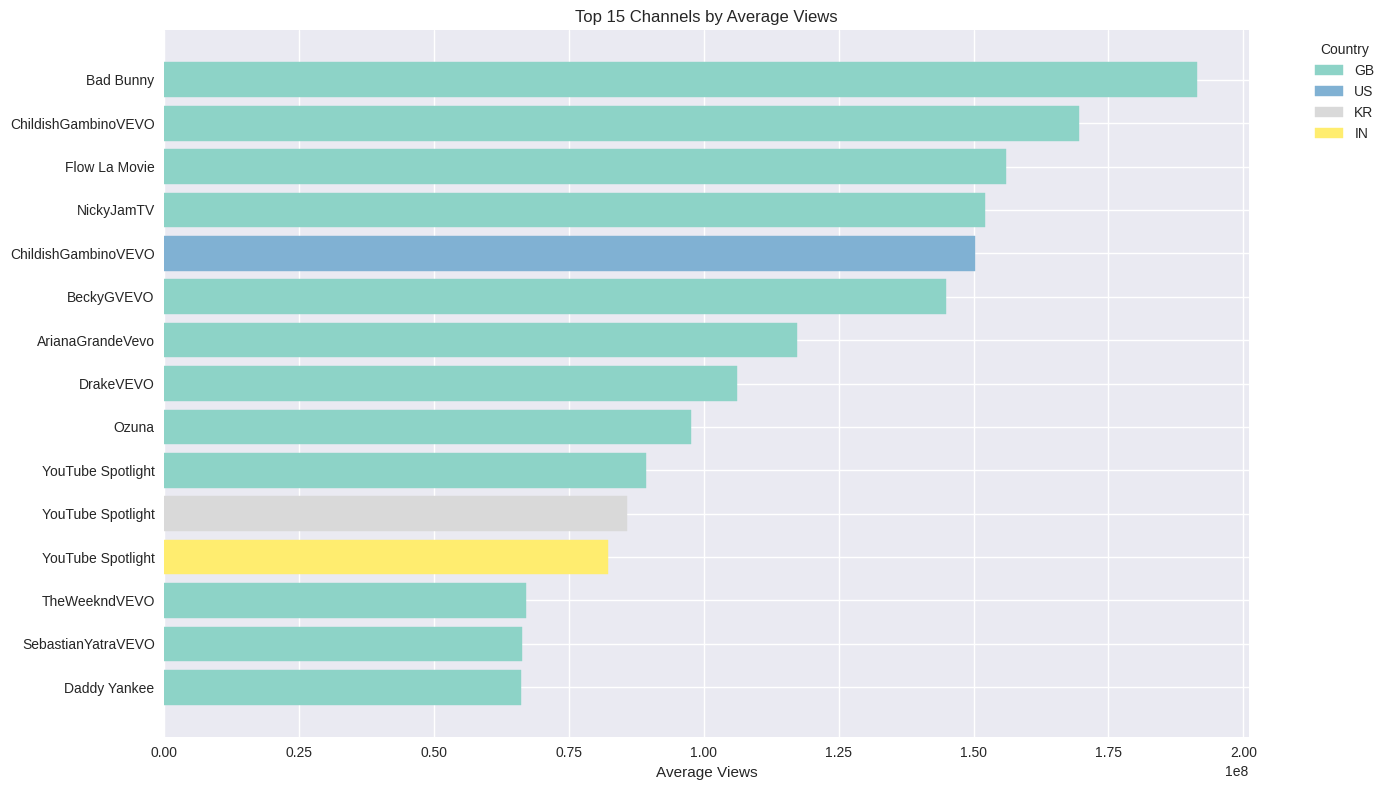

In [9]:
# 3. Channel Success Analysis
print("Top Performing Channels Analysis")

# Top channels by average views
top_channels = channel_pd.nlargest(15, "avg_views")
plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(top_channels)), top_channels["avg_views"])
plt.yticks(range(len(top_channels)), top_channels["channel_title"])
plt.xlabel("Average Views")
plt.title("Top 15 Channels by Average Views")
plt.gca().invert_yaxis()

# Color bars by country
colors = plt.cm.Set3(np.linspace(0, 1, len(top_channels["country"].unique())))
country_colors = dict(zip(top_channels["country"].unique(), colors))
for i, bar in enumerate(bars):
    bar.set_color(country_colors[top_channels.iloc[i]["country"]])

# Add legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in country_colors.values()]
plt.legend(handles, country_colors.keys(), title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


#### 2.4. Temporal Trends Analysis

This section analyzes daily trends in video views:
- Global Trends: A line plot of total daily views across all countries.
- Country-Specific Trends: A line plot showing daily views for each country.

These plots reveal temporal patterns in video popularity, helping identify peak trending periods.

Temporal Trends Analysis


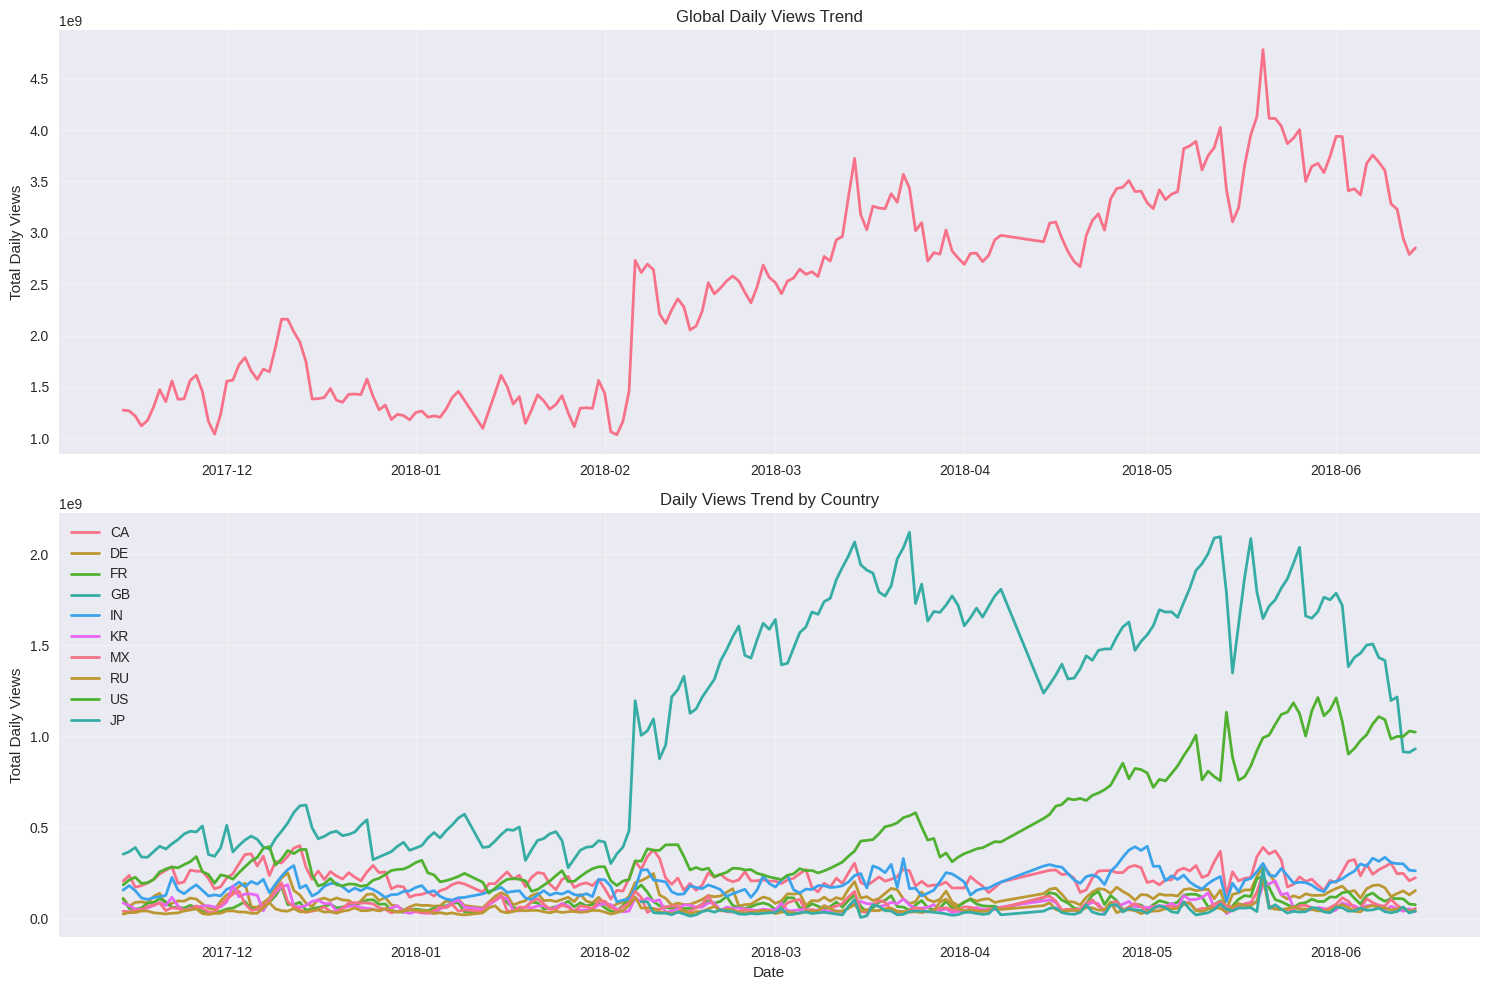

In [10]:
# 4. Temporal Trends Analysis
print("Temporal Trends Analysis")

# Convert trending_date_parsed to datetime
daily_pd["trending_date_parsed"] = pd.to_datetime(daily_pd["trending_date_parsed"])

# Daily trends
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Total daily views across all countries
daily_global = daily_pd.groupby("trending_date_parsed")["total_daily_views"].sum()
axes[0].plot(daily_global.index, daily_global.values, linewidth=2)
axes[0].set_title("Global Daily Views Trend")
axes[0].set_ylabel("Total Daily Views")
axes[0].grid(True, alpha=0.3)

# Daily views by country
for country in daily_pd["country"].unique():
    country_data = daily_pd[daily_pd["country"] == country]
    country_daily = country_data.groupby("trending_date_parsed")["total_daily_views"].sum()
    axes[1].plot(country_daily.index, country_daily.values, label=country, linewidth=2)

axes[1].set_title("Daily Views Trend by Country")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Total Daily Views")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#### 2.5. Interactive Visualizations

Using Plotly, this section creates interactive plots for:
- Category Performance: A treemap showing total views by country and category, colored by engagement rate.
- Channel Comparison: A scatter plot of the top 20 channels by average views versus like ratio, sized by trending count.
- Time Series: A line plot of daily views by country.

These interactive visualizations allow for dynamic data exploration ([Plotly Documentation](https://plotly.com/python/)).

Creating Interactive Visualizations...


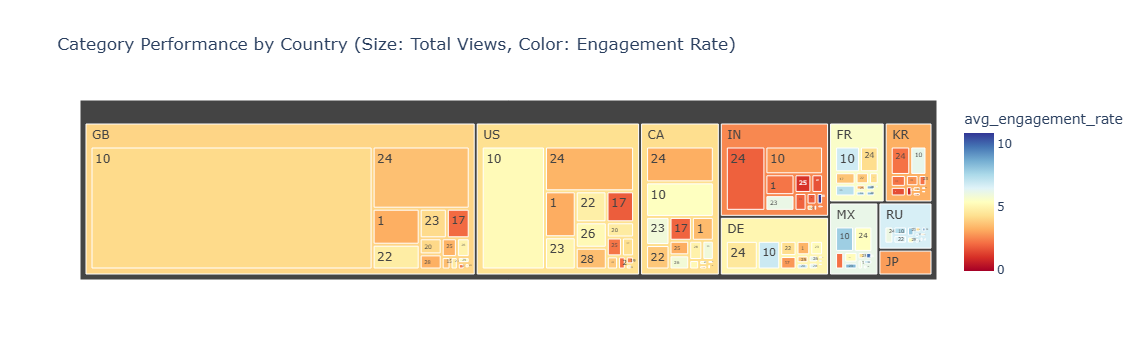

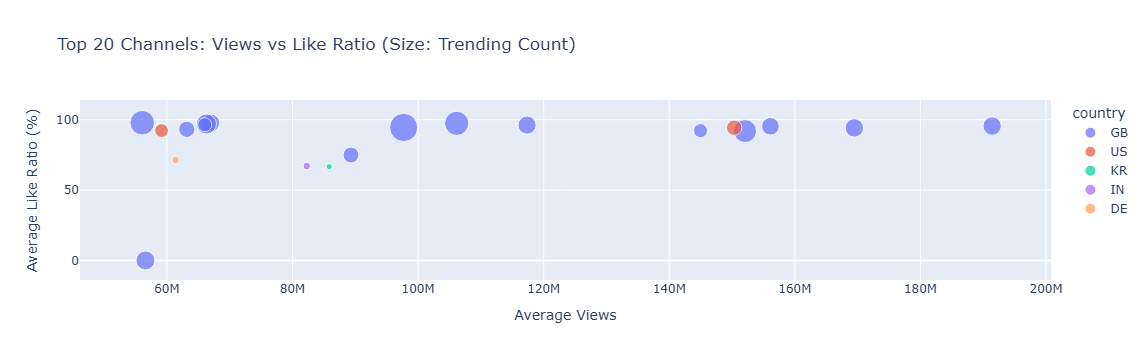

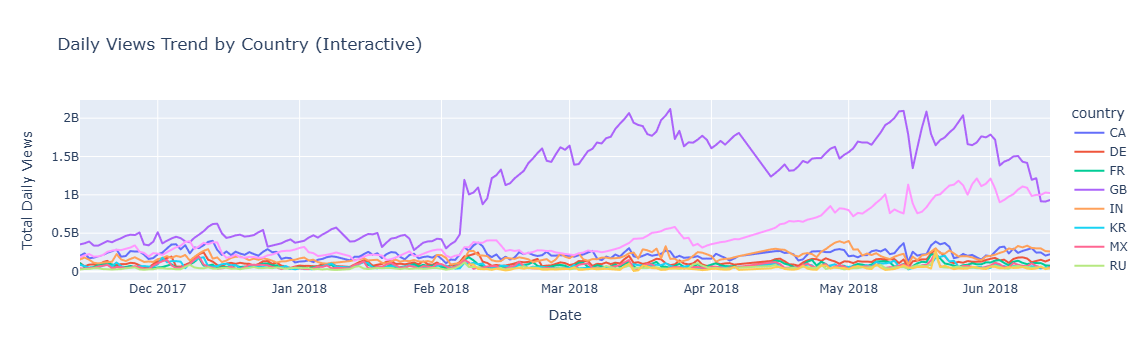

In [11]:
# 5. Interactive Plotly Visualizations
print("Creating Interactive Visualizations...")

# Interactive category performance
fig = px.treemap(
    category_pd,
    path=["country", "category_id"],
    values="total_views",
    color="avg_engagement_rate",
    title="Category Performance by Country (Size: Total Views, Color: Engagement Rate)",
    color_continuous_scale="RdYlBu",
)
fig.show()

# Interactive channel comparison
top_20_channels = channel_pd.nlargest(20, "avg_views")
fig = px.scatter(
    top_20_channels,
    x="avg_views",
    y="avg_like_ratio",
    size="trending_count",
    color="country",
    hover_data=["channel_title"],
    title="Top 20 Channels: Views vs Like Ratio (Size: Trending Count)",
    labels={"avg_views": "Average Views", "avg_like_ratio": "Average Like Ratio (%)"},
)
fig.show()

# Interactive time series
fig = px.line(
    daily_pd,
    x="trending_date_parsed",
    y="total_daily_views",
    color="country",
    title="Daily Views Trend by Country (Interactive)",
    labels={"trending_date_parsed": "Date", "total_daily_views": "Total Daily Views"},
)
fig.show()


#### 2.6. Correlation Analysis

This section computes and visualizes a correlation matrix for channel metrics (average views, maximum views, trending count, and average like ratio) using a Seaborn heatmap. This analysis uncovers relationships between metrics that may influence video success.

Correlation Analysis


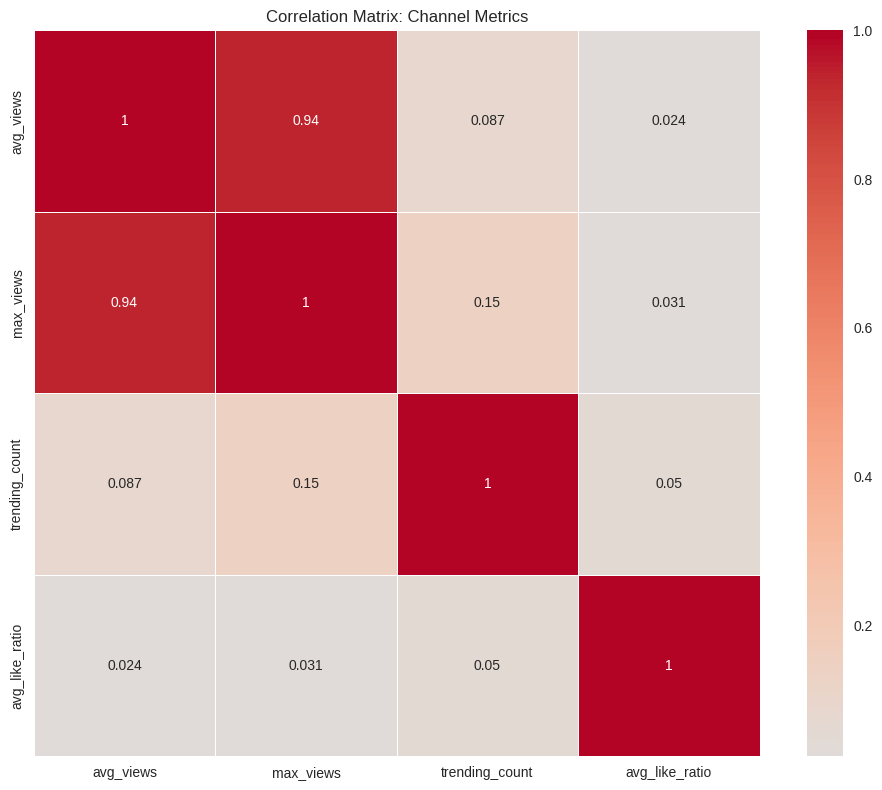

In [12]:
# 6. Correlation Analysis
print("Correlation Analysis")

# Prepare data for correlation
correlation_data = channel_pd[["avg_views", "max_views", "trending_count", "avg_like_ratio"]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data, annot=True, cmap="coolwarm", center=0, square=True, linewidths=0.5)
plt.title("Correlation Matrix: Channel Metrics")
plt.tight_layout()
plt.show()


#### 2.7. Summary Statistics

Key statistics are compiled, including:
- Total number of countries, categories, and channels.
- Average views and engagement rate.
- Most popular country and category by total views.
- Top channel by average views.

| Metric | Description |
|--------|-------------|
| Total Countries | Number of unique countries analyzed |
| Total Categories | Number of unique video categories |
| Total Channels | Number of unique channels analyzed |
| Average Views | Mean views per video across categories |
| Average Engagement Rate | Mean engagement rate across categories |
| Most Popular Country | Country with the highest total views |
| Most Popular Category | Category with the highest total views |
| Top Channel | Channel with the highest average views |

In [13]:
# 7. Summary Statistics
print("Summary Statistics")
print("=" * 50)

summary_stats = {
    "Total Countries": category_pd["country"].nunique(),
    "Total Categories": category_pd["category_id"].nunique(),
    "Total Channels Analyzed": channel_pd["channel_title"].nunique(),
    "Average Views per Video": category_pd["avg_views"].mean(),
    "Average Engagement Rate": category_pd["avg_engagement_rate"].mean(),
    "Most Popular Country": category_pd.groupby("country")["total_views"].sum().idxmax(),
    "Most Popular Category": category_pd.groupby("category_id")["total_views"].sum().idxmax(),
    "Top Channel": channel_pd.loc[channel_pd["avg_views"].idxmax(), "channel_title"],
}

for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:,.2f}")
    else:
        print(f"{key}: {value}")


Summary Statistics
Total Countries: 10
Total Categories: 18
Total Channels Analyzed: 24388
Average Views per Video: 899,414.11
Average Engagement Rate: 4.36
Most Popular Country: GB
Most Popular Category: 10
Top Channel: Bad Bunny


#### 2.8. Export Results to S3

The analysis results, including summary statistics and detailed datasets, are exported to the `youtube-trending-analytics` S3 bucket as CSV files. This ensures that the findings are preserved for future reference or further analysis.

In [14]:
# 8. Export Results to S3
print("Exporting analysis results to LocalStack S3...")

try:
    # Create summary DataFrame
    summary_df = pd.DataFrame([summary_stats])

    # Save to CSV
    summary_csv = summary_df.to_csv(index=False)

    # Upload to S3
    s3_client.put_object(Bucket="youtube-trending-analytics", Key="analysis/summary_statistics.csv", Body=summary_csv, ContentType="text/csv")

    # Save detailed analysis
    category_csv = category_pd.to_csv(index=False)
    s3_client.put_object(Bucket="youtube-trending-analytics", Key="analysis/category_analysis_detailed.csv", Body=category_csv, ContentType="text/csv")

    channel_csv = channel_pd.to_csv(index=False)
    s3_client.put_object(Bucket="youtube-trending-analytics", Key="analysis/channel_analysis_detailed.csv", Body=channel_csv, ContentType="text/csv")

    print("Analysis results exported to S3 successfully!")

except Exception as e:
    print(f"Error exporting to S3: {e}")


Exporting analysis results to LocalStack S3...
Analysis results exported to S3 successfully!


#### 2.9. Cleanup
The Spark session is closed to free up computational resources, ensuring efficient resource management.

In [15]:
# Cleanup
print("Cleaning up...")
spark.stop()
print("Spark session closed")
print("\nAnalysis completed successfully!")
print("Check LocalStack S3 bucket 'youtube-trending-analytics' for exported results")


Cleaning up...
Spark session closed

Analysis completed successfully!
Check LocalStack S3 bucket 'youtube-trending-analytics' for exported results
